## Импорт бибилиотек и функции

In [1]:
# импорт нужных бибилиотек
import os
import cv2
import glob
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from keras.utils import to_categorical

from tensorflow.keras.applications.xception import Xception

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split

In [2]:
def plot_training_curves(history):

  tr_acc = history.history['accuracy']
  tr_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]
  epochs = [i+1 for i in range(len(tr_acc))] # количество эпох обучения
  loss_label = f'best epoch = {str(index_loss + 1)}'
  acc_label = f'best epoch = {str(index_acc + 1)}'

  # Plot training history
  plt.figure(figsize= (12, 5))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(epochs, tr_loss, 'r', label='Ошибка обучения')
  plt.plot(epochs, val_loss, 'g', label='Ошибка валидации')
  plt.scatter(index_loss + 1, val_lowest, s=150, c= 'blue', label=loss_label)
  plt.title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение ошибки', fontsize=12)
  plt.legend(fontsize=12)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, tr_acc, 'r', label='Точность обучения')
  plt.plot(epochs, val_acc, 'g', label='Точность валидации')
  plt.scatter(index_acc + 1 , acc_highest, s=150, c= 'blue', label=acc_label)
  plt.title('Точность при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение точности', fontsize=12)
  plt.legend(fontsize=12)

  plt.tight_layout
  plt.show()

  return

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=12, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  model_roc_auc = roc_auc_score(y_true, y_probabilities)


  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')

  return

def plot_roc_curve(y_test, y_prob):
  plt.figure(figsize=(5, 4))
  auc = roc_auc_score(y_test, y_prob)
  fper, tper, thresholds = roc_curve(y_test, y_prob)
  plt.plot(fper, tper, label=f"AUC = {round(auc, 3)}")
  plt.plot([0, 1], [0, 1], color="black", linestyle="--")
  plt.xlabel("False Positive Rate", fontsize=12)
  plt.ylabel("True Positive Rate", fontsize=12)
  plt.title("График ROC-кривой", fontsize=12, fontweight="bold")
  plt.grid()
  plt.legend(loc=4)
  plt.show()

## Загрузка набора данных

In [3]:
# получение токена для загрузки набора данных с сайта kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dashkabugashka","key":"120cb24fa13253988e528a5054fa0b13"}'}

In [4]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Dec 21 01:53 kaggle.json


In [5]:
# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d emmarex/plantdisease

 99% 651M/658M [00:09<00:00, 91.4MB/s]
100% 658M/658M [00:09<00:00, 70.8MB/s]


## Чтение данных

In [ ]:
# разархивирование данных
!unzip "/content/plantdisease.zip" -d "/content/plantdisease"

In [61]:
#'septoria',
disease_types = ['yellow_leaf', 'healthy']
data_dir = '/content/plantdisease/PlantVillage/'
train_dir = os.path.join(data_dir)

In [65]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

df = pd.DataFrame(train_data, columns=['file_path', 'disease_id','disease_type'])

# Исследование данных

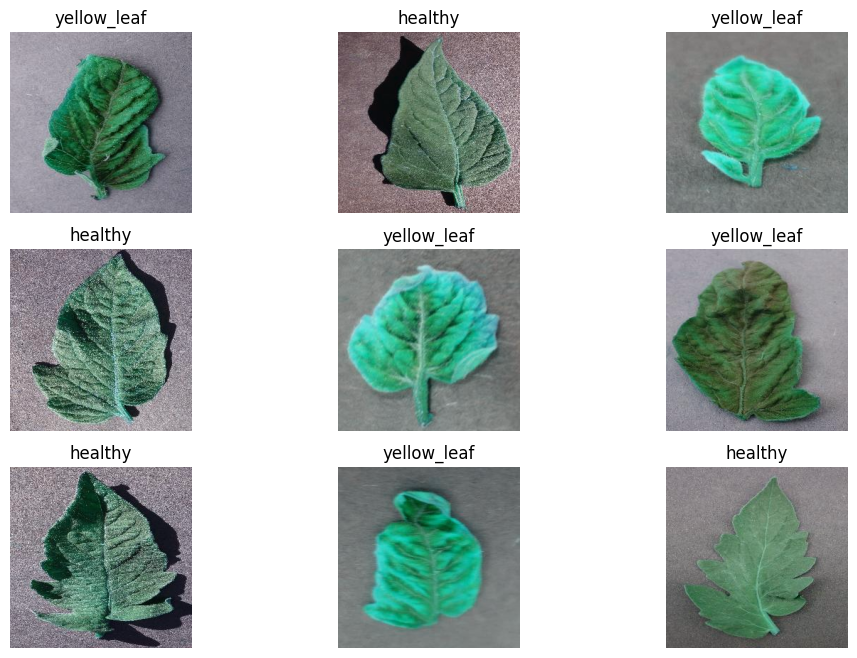

In [81]:
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    random_index = random.randint(0, len(df) - 1)
    image_path = os.path.join(data_dir, df['file_path'][random_index])
    plt.imshow(cv2.imread(image_path))
    plt.title(df['disease_type'][random_index])
    plt.axis('off')

In [115]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [116]:
X_train = np.zeros((df.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(df['file_path'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

4800it [00:06, 688.34it/s]


Train Shape: (4800, 64, 64, 3)


In [117]:
y_train = df['disease_id'].values
y_train

array([0, 0, 0, ..., 1, 1, 1])

# Деление на выборки

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 3072
Размер валидационной выборки: 768
Размер тестовой выборки: 960


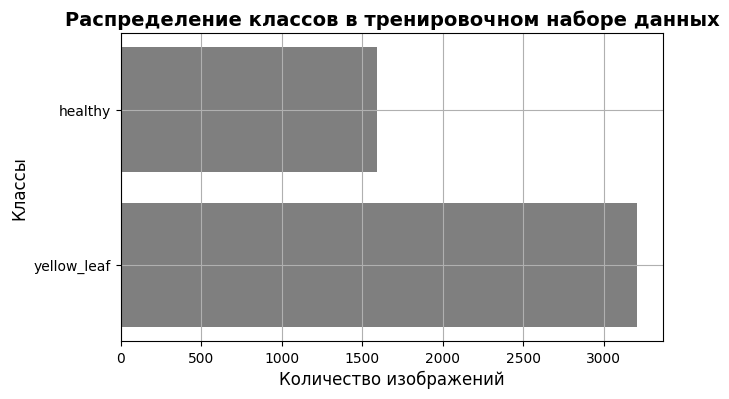

In [119]:
# количество изображений в тренировочной выборке на каждй класс
train = df['disease_type'].value_counts()
label = train.tolist()
index = train.index.tolist()

plt.figure(figsize=(7, 4))
plt.title("Распределение классов в тренировочном наборе данных", fontsize=14, fontweight="bold")
plt.xlabel("Количество изображений", fontsize=12)
plt.ylabel("Классы", fontsize=12)
plt.barh(index, label, color="#7f7f7f")
plt.yticks([0, 1], index)
plt.grid(True)
plt.show()

# Обучение без аугментации (бинарный)

In [20]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

callbacks_list=[early_stop]

## Модель 1

In [121]:
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(2, kernel_size=(1, 1), activation="tanh"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 2)         8         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 2)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2057 (8.04 KB)
Trainable params: 2057 (8.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [122]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
96/96 [==============================] - 3s 20ms/step - loss: 4.1698 - accuracy: 0.8258 - val_loss: 0.4089 - val_accuracy: 0.9570
Epoch 2/10
96/96 [==============================] - 3s 27ms/step - loss: 1.3136 - accuracy: 0.9141 - val_loss: 1.0914 - val_accuracy: 0.9102
Epoch 3/10
96/96 [==============================] - 2s 20ms/step - loss: 0.5938 - accuracy: 0.9541 - val_loss: 1.1495 - val_accuracy: 0.9258
Epoch 4/10
96/96 [==============================] - 2s 16ms/step - loss: 1.8363 - accuracy: 0.9027 - val_loss: 3.9750 - val_accuracy: 0.8672
Epoch 5/10
96/96 [==============================] - 2s 16ms/step - loss: 2.0921 - accuracy: 0.9297 - val_loss: 5.3740 - val_accuracy: 0.8568
Epoch 6/10
96/96 [==============================] - 2s 16ms/step - loss: 1.3239 - accuracy: 0.9430 - val_loss: 0.6541 - val_accuracy: 0.9544
Epoch 6: early stopping


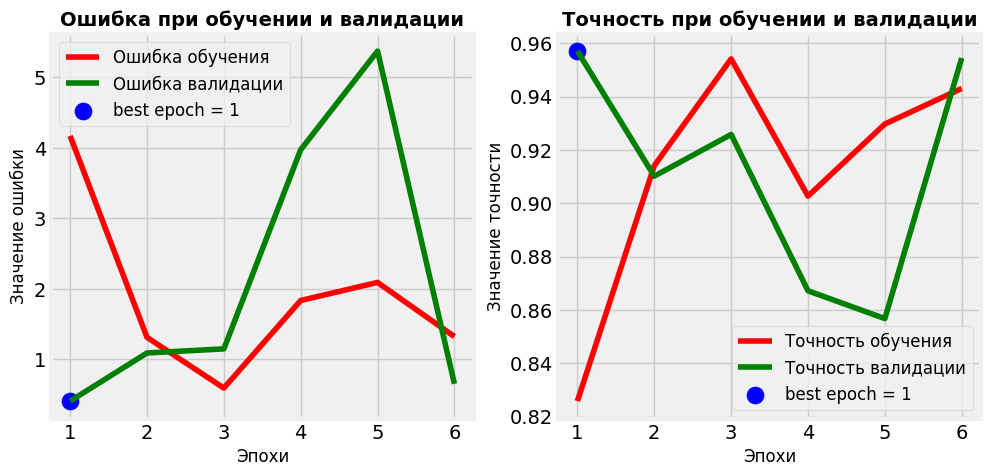

In [123]:
plot_training_curves(history)

In [124]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

30/30 [==============================] - 0s 7ms/step


In [125]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9494
Precision_score:	0.8622
Recall_score:		0.9703
AUC Score:		0.9864


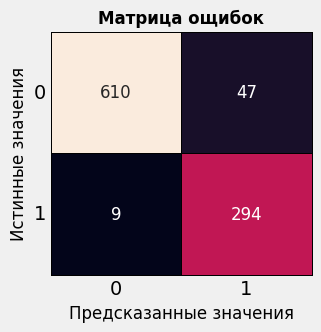

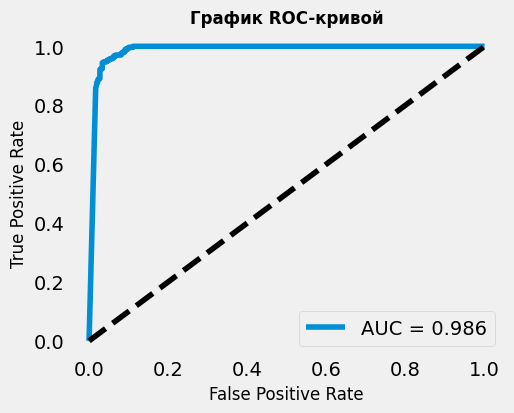

In [128]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [139]:
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(2, kernel_size=(1, 1), activation="tanh"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.SGD()

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 2)         8         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 2)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 2057 (8.04 KB)
Trainable params: 2057 (8.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [140]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
96/96 [==============================] - 3s 18ms/step - loss: 1.8434 - accuracy: 0.5391 - val_loss: 1.2668 - val_accuracy: 0.3307
Epoch 2/10
96/96 [==============================] - 2s 16ms/step - loss: 1.5694 - accuracy: 0.5693 - val_loss: 1.7822 - val_accuracy: 0.3750
Epoch 3/10
96/96 [==============================] - 4s 39ms/step - loss: 0.3843 - accuracy: 0.8734 - val_loss: 0.3117 - val_accuracy: 0.8516
Epoch 4/10
96/96 [==============================] - 4s 44ms/step - loss: 0.1583 - accuracy: 0.9505 - val_loss: 0.3000 - val_accuracy: 0.8893
Epoch 5/10
96/96 [==============================] - 3s 30ms/step - loss: 0.1091 - accuracy: 0.9661 - val_loss: 0.0724 - val_accuracy: 0.9792
Epoch 6/10
96/96 [==============================] - 2s 24ms/step - loss: 0.0883 - accuracy: 0.9707 - val_loss: 0.0712 - val_accuracy: 0.9831
Epoch 7/10
96/96 [==============================] - 3s 30ms/step - loss: 0.0856 - accuracy: 0.9710 - val_loss: 0.0973 - val_accuracy: 0.9635
Epoch 8/10
96

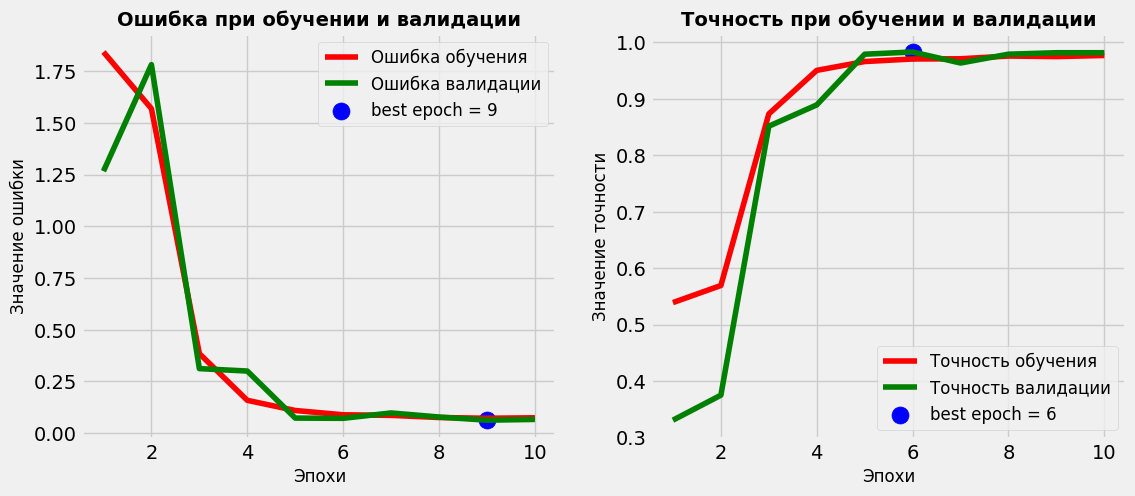

In [141]:
plot_training_curves(history)

In [142]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

30/30 [==============================] - 0s 7ms/step


In [143]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9876
Precision_score:	0.9617
Recall_score:		0.9934
AUC Score:		0.9979


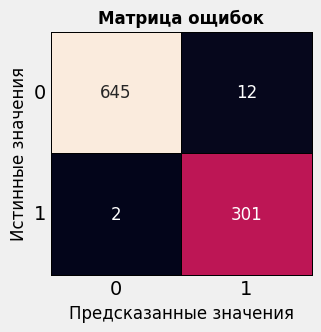

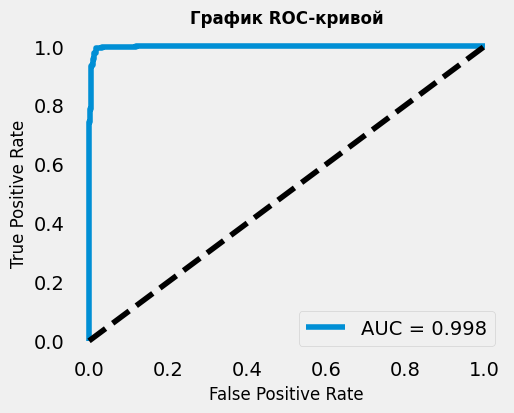

In [144]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 3

In [145]:
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(4, kernel_size=(2, 2), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 63, 63, 4)         52        
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 31, 31, 4)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 3844)              0         
                                                                 
 dense_8 (Dense)             (None, 1)                 3845      
                                                                 
Total params: 3897 (15.22 KB)
Trainable params: 3897 (15.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [146]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
96/96 [==============================] - 4s 41ms/step - loss: 17.2410 - accuracy: 0.8118 - val_loss: 0.3950 - val_accuracy: 0.9701
Epoch 2/10
96/96 [==============================] - 4s 39ms/step - loss: 0.5789 - accuracy: 0.9691 - val_loss: 0.4315 - val_accuracy: 0.9674
Epoch 3/10
96/96 [==============================] - 3s 34ms/step - loss: 0.3603 - accuracy: 0.9782 - val_loss: 0.4476 - val_accuracy: 0.9727
Epoch 4/10
96/96 [==============================] - 3s 34ms/step - loss: 0.2202 - accuracy: 0.9860 - val_loss: 0.5791 - val_accuracy: 0.9635
Epoch 5/10
96/96 [==============================] - 4s 40ms/step - loss: 0.1976 - accuracy: 0.9873 - val_loss: 0.6591 - val_accuracy: 0.9596
Epoch 6/10
96/96 [==============================] - 4s 37ms/step - loss: 0.4316 - accuracy: 0.9740 - val_loss: 0.6532 - val_accuracy: 0.9674
Epoch 7/10
96/96 [==============================] - 3s 31ms/step - loss: 0.3319 - accuracy: 0.9811 - val_loss: 0.4074 - val_accuracy: 0.9857
Epoch 8/10
9

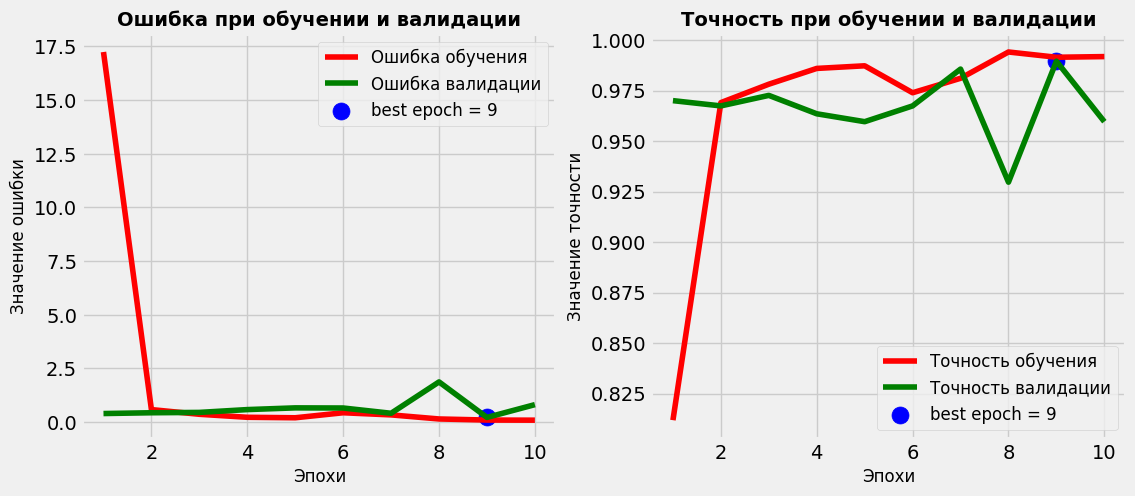

In [147]:
plot_training_curves(history)

In [148]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

30/30 [==============================] - 0s 14ms/step


In [149]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9472
Precision_score:	1.0000
Recall_score:		0.8944
AUC Score:		0.9998


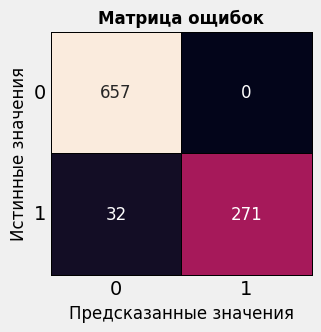

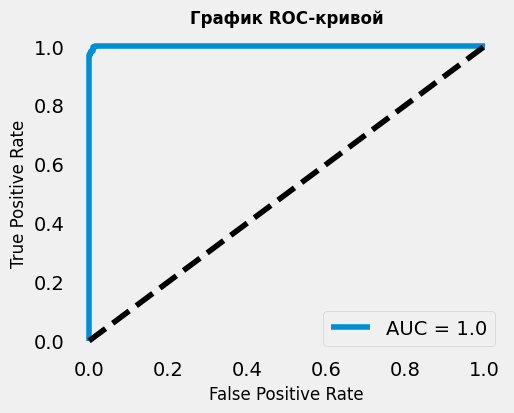

In [150]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 4

In [151]:
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 4)         112       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 4)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 3844)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 3845      
                                                                 
Total params: 3957 (15.46 KB)
Trainable params: 3957 (15.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [152]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
96/96 [==============================] - 4s 39ms/step - loss: 10.4492 - accuracy: 0.5960 - val_loss: 2.6373 - val_accuracy: 0.7865
Epoch 2/10
96/96 [==============================] - 5s 50ms/step - loss: 1.9848 - accuracy: 0.8340 - val_loss: 1.5943 - val_accuracy: 0.8698
Epoch 3/10
96/96 [==============================] - 4s 42ms/step - loss: 1.2135 - accuracy: 0.8981 - val_loss: 1.0304 - val_accuracy: 0.9010
Epoch 4/10
96/96 [==============================] - 4s 39ms/step - loss: 0.8166 - accuracy: 0.9209 - val_loss: 0.6629 - val_accuracy: 0.9284
Epoch 5/10
96/96 [==============================] - 4s 41ms/step - loss: 0.5992 - accuracy: 0.9368 - val_loss: 0.4785 - val_accuracy: 0.9388
Epoch 6/10
96/96 [==============================] - 5s 51ms/step - loss: 0.4843 - accuracy: 0.9473 - val_loss: 0.5052 - val_accuracy: 0.9414
Epoch 7/10
96/96 [==============================] - 3s 36ms/step - loss: 0.4070 - accuracy: 0.9570 - val_loss: 0.3221 - val_accuracy: 0.9544
Epoch 8/10
9

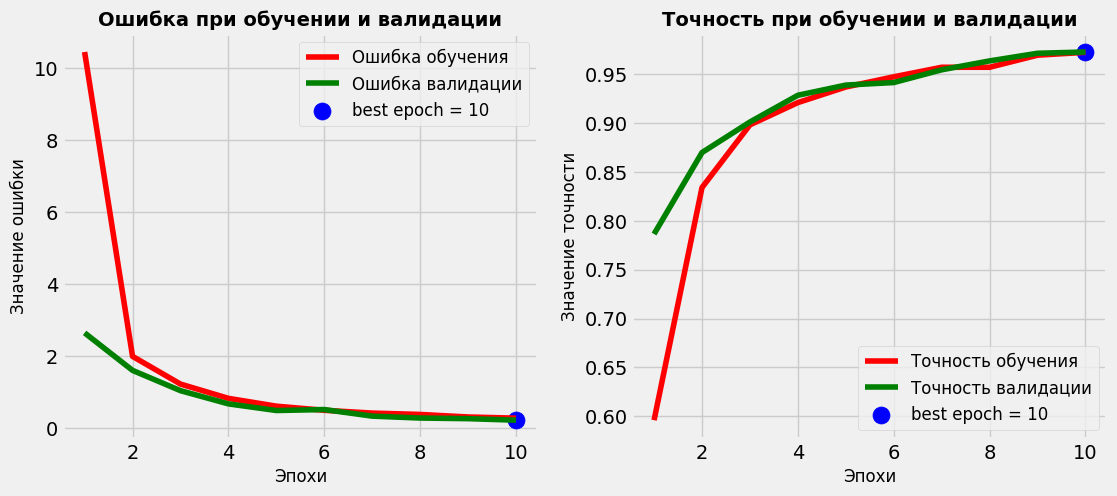

In [153]:
plot_training_curves(history)

In [154]:
y_predicted_prob = model.predict(X_test)
y_predicted = (y_predicted_prob > 0.5).astype(int)

30/30 [==============================] - 1s 15ms/step


In [155]:
model_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9659
Precision_score:	0.9329
Recall_score:		0.9637
AUC Score:		0.9953


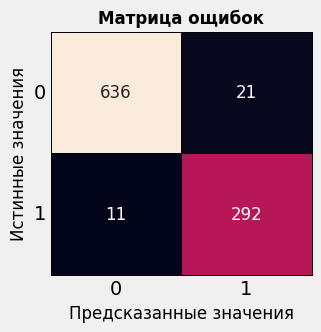

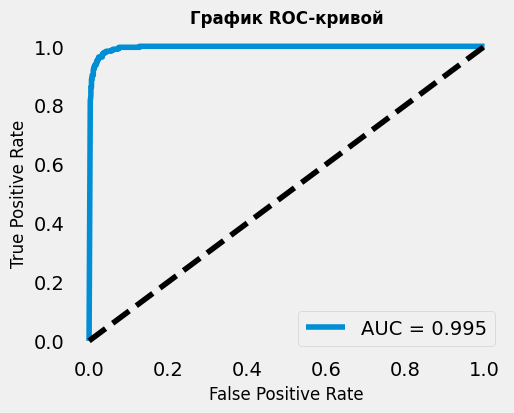

In [156]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 5

In [157]:
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 4)         112       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 31, 31, 4)         0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 31, 31, 4)         0         
                                                                 
 flatten_10 (Flatten)        (None, 3844)              0         
                                                                 
 dense_10 (Dense)            (None, 1)                 3845      
                                                                 
Total params: 3957 (15.46 KB)
Trainable params: 3957 (15.46 KB)
Non-trainable params: 0 (0.00 Byte)
___________________

In [158]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
96/96 [==============================] - 7s 70ms/step - loss: 9.1130 - accuracy: 0.6064 - val_loss: 3.0987 - val_accuracy: 0.6875
Epoch 2/10
96/96 [==============================] - 4s 41ms/step - loss: 4.5879 - accuracy: 0.6826 - val_loss: 0.5444 - val_accuracy: 0.9167
Epoch 3/10
96/96 [==============================] - 4s 38ms/step - loss: 0.8743 - accuracy: 0.9092 - val_loss: 0.2684 - val_accuracy: 0.9688
Epoch 4/10
96/96 [==============================] - 5s 53ms/step - loss: 0.5539 - accuracy: 0.9430 - val_loss: 0.2066 - val_accuracy: 0.9714
Epoch 5/10
96/96 [==============================] - 4s 44ms/step - loss: 0.3875 - accuracy: 0.9583 - val_loss: 0.2112 - val_accuracy: 0.9740
Epoch 6/10
96/96 [==============================] - 4s 39ms/step - loss: 0.3343 - accuracy: 0.9583 - val_loss: 0.0876 - val_accuracy: 0.9883
Epoch 7/10
96/96 [==============================] - 5s 47ms/step - loss: 0.2647 - accuracy: 0.9707 - val_loss: 0.0676 - val_accuracy: 0.9922
Epoch 8/10
96

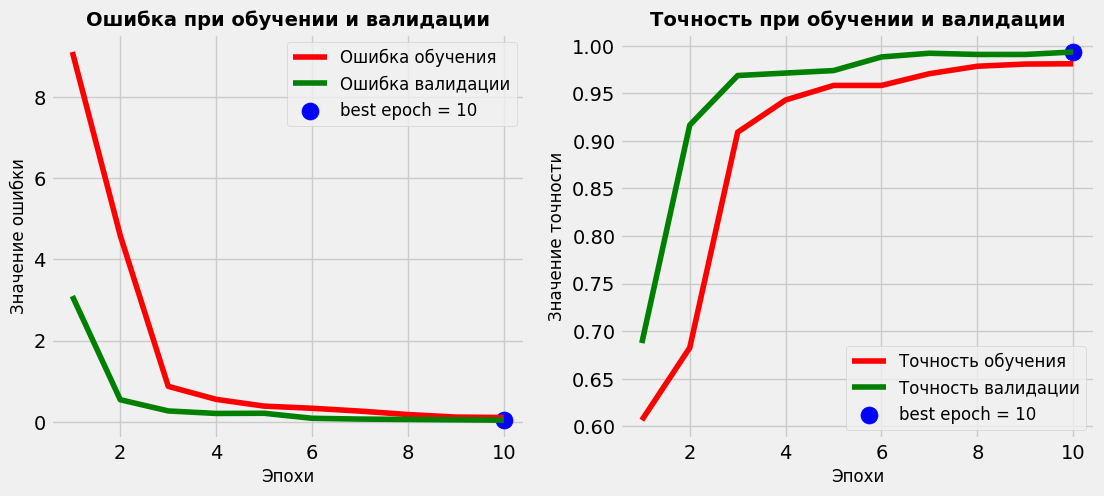

In [159]:
plot_training_curves(history)

In [160]:
y_predicted_prob = model.predict(X_test)
y_predicted = (y_predicted_prob > 0.5).astype(int)

30/30 [==============================] - 1s 27ms/step


In [161]:
model_preformance = generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9874
Precision_score:	0.9677
Recall_score:		0.9901
AUC Score:		0.9976


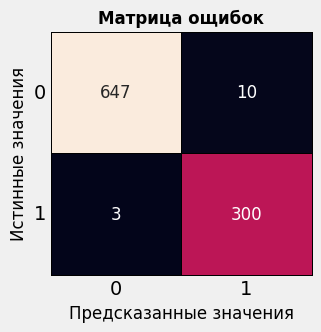

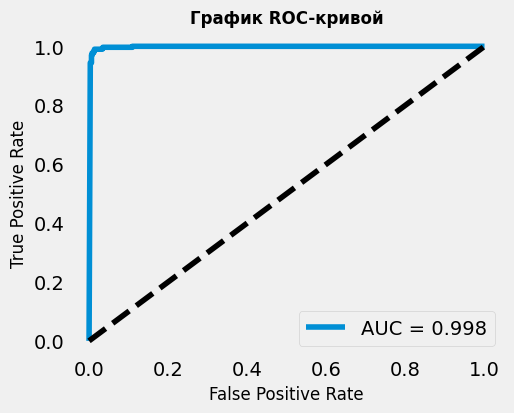

In [162]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

# Обучение аугментация (бинарный)

In [163]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20,
  zoom_range=0.15,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.15,
  horizontal_flip=True,
  fill_mode="nearest")

## Модель 1

In [164]:
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(2, kernel_size=(1, 1), activation="tanh"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 64, 64, 2)         8         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 32, 32, 2)         0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_11 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 2057 (8.04 KB)
Trainable params: 2057 (8.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [165]:
history = model.fit(x=aug.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
96/96 [==============================] - 8s 71ms/step - loss: 14.1600 - accuracy: 0.5550 - val_loss: 12.9245 - val_accuracy: 0.3307
Epoch 2/10
96/96 [==============================] - 11s 111ms/step - loss: 13.4261 - accuracy: 0.5622 - val_loss: 7.0581 - val_accuracy: 0.6693
Epoch 3/10
96/96 [==============================] - 5s 55ms/step - loss: 9.5702 - accuracy: 0.5358 - val_loss: 35.8824 - val_accuracy: 0.6693
Epoch 4/10
96/96 [==============================] - 7s 74ms/step - loss: 14.6903 - accuracy: 0.5605 - val_loss: 25.1765 - val_accuracy: 0.6693
Epoch 5/10
96/96 [==============================] - 5s 55ms/step - loss: 10.7283 - accuracy: 0.5452 - val_loss: 1.6081 - val_accuracy: 0.6693
Epoch 6/10
96/96 [==============================] - 7s 68ms/step - loss: 10.0395 - accuracy: 0.5482 - val_loss: 25.8208 - val_accuracy: 0.6693
Epoch 7/10
96/96 [==============================] - 7s 72ms/step - loss: 12.6468 - accuracy: 0.5456 - val_loss: 19.6707 - val_accuracy: 0.3307


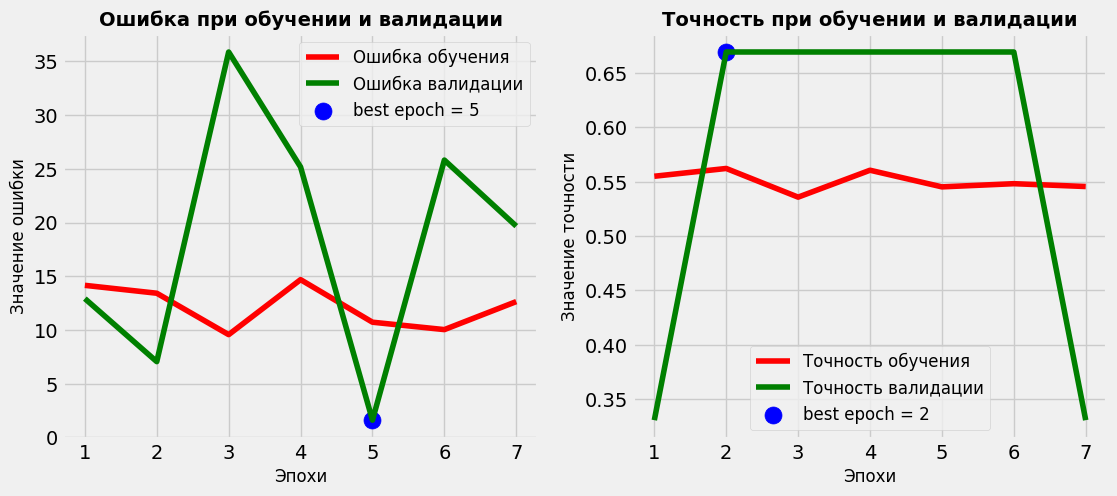

In [166]:
plot_training_curves(history)

In [167]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

30/30 [==============================] - 0s 6ms/step


In [168]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.5000
Precision_score:	0.3156
Recall_score:		1.0000
AUC Score:		0.5000


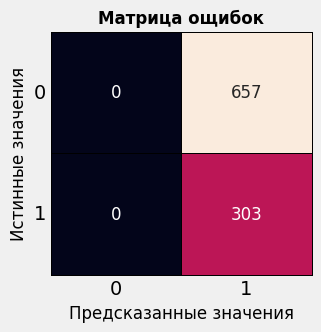

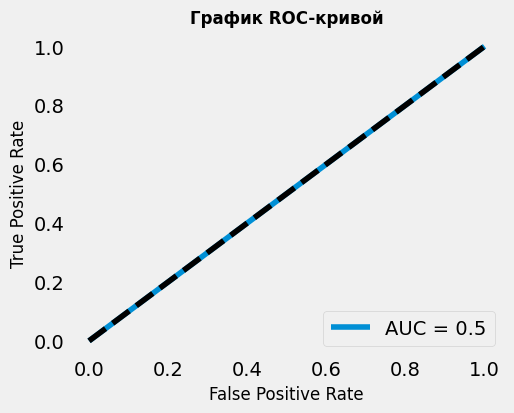

In [169]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

## Модель 2

In [170]:
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(2, kernel_size=(1, 1), activation="tanh"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid")
])

optimizer = tf.keras.optimizers.SGD()

# компиляция модели
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 2)         8         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 32, 32, 2)         0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 2057 (8.04 KB)
Trainable params: 2057 (8.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [171]:
history = model.fit(x=aug.flow(X_train, y_train, batch_size=32),
                    epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
96/96 [==============================] - 6s 57ms/step - loss: 0.4140 - accuracy: 0.8548 - val_loss: 0.1265 - val_accuracy: 0.9596
Epoch 2/10
96/96 [==============================] - 8s 79ms/step - loss: 0.1692 - accuracy: 0.9437 - val_loss: 0.1926 - val_accuracy: 0.9531
Epoch 3/10
96/96 [==============================] - 5s 55ms/step - loss: 0.1738 - accuracy: 0.9385 - val_loss: 0.2149 - val_accuracy: 0.9466
Epoch 4/10
96/96 [==============================] - 5s 56ms/step - loss: 0.1451 - accuracy: 0.9512 - val_loss: 0.1137 - val_accuracy: 0.9661
Epoch 5/10
96/96 [==============================] - 6s 62ms/step - loss: 0.1538 - accuracy: 0.9476 - val_loss: 0.1222 - val_accuracy: 0.9753
Epoch 6/10
96/96 [==============================] - 5s 56ms/step - loss: 0.1661 - accuracy: 0.9440 - val_loss: 0.1196 - val_accuracy: 0.9609
Epoch 7/10
96/96 [==============================] - 5s 55ms/step - loss: 0.1690 - accuracy: 0.9460 - val_loss: 0.1392 - val_accuracy: 0.9635
Epoch 8/10
96

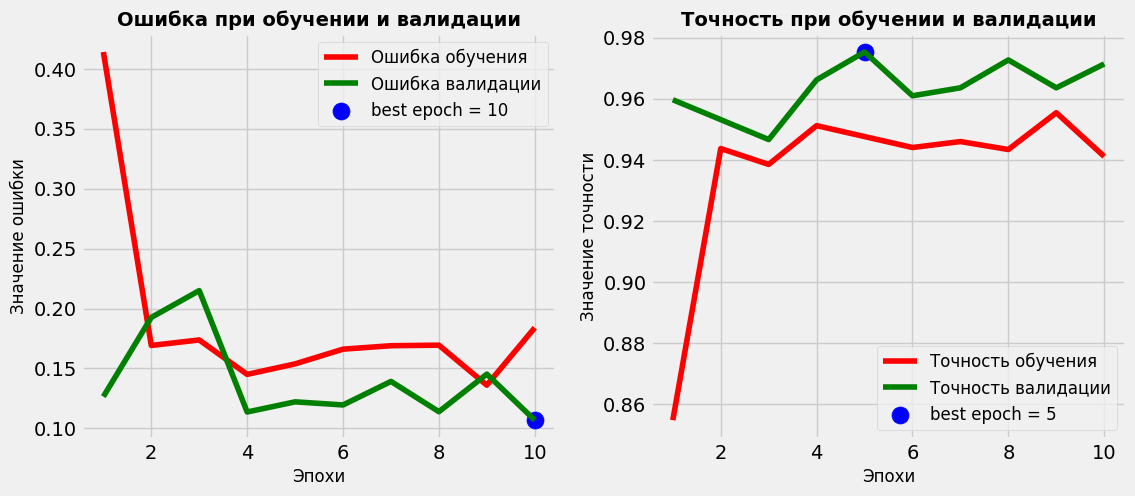

In [172]:
plot_training_curves(history)

In [173]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = (y_predicted_prob > 0.5).astype(int) # перевод вероятностей в метки [0, 1] с порогом 0.5

30/30 [==============================] - 0s 6ms/step


In [174]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9631
Precision_score:	0.9102
Recall_score:		0.9703
AUC Score:		0.9947


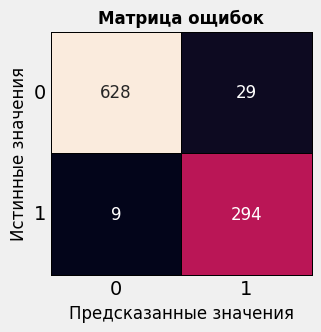

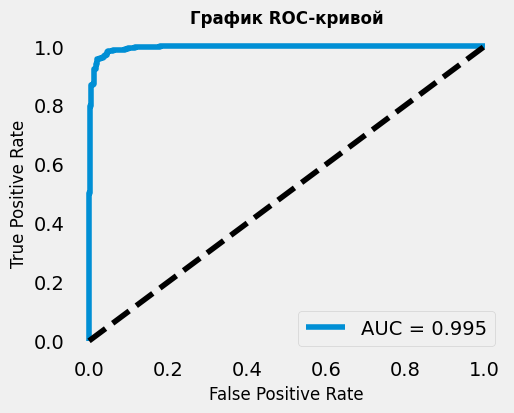

In [175]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_roc_curve(y_test, y_predicted_prob)

# Чтение данных

In [ ]:
# разархивирование данных
!unzip "/content/plantdisease.zip" -d "/content/plantdisease"

In [8]:
disease_types = ['septoria', 'yellow_leaf', 'healthy']
data_dir = '/content/plantdisease/PlantVillage/'
train_dir = os.path.join(data_dir)

In [9]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

df = pd.DataFrame(train_data, columns=['file_path', 'disease_id','disease_type'])

# Исследование данных

In [10]:
IMAGE_SIZE = 71

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [33]:
X_train = np.zeros((df.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(df['file_path'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

6571it [00:18, 347.91it/s]


Train Shape: (6571, 71, 71, 3)


In [34]:
y_train = df['disease_id'].values
y_train

array([0, 0, 0, ..., 2, 2, 2])

# Деление на выборки

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

print(f"Размер тренировочной выборки: {X_train.shape[0]}")
print(f"Размер валидационной выборки: {X_val.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Размер тренировочной выборки: 4204
Размер валидационной выборки: 1052
Размер тестовой выборки: 1315


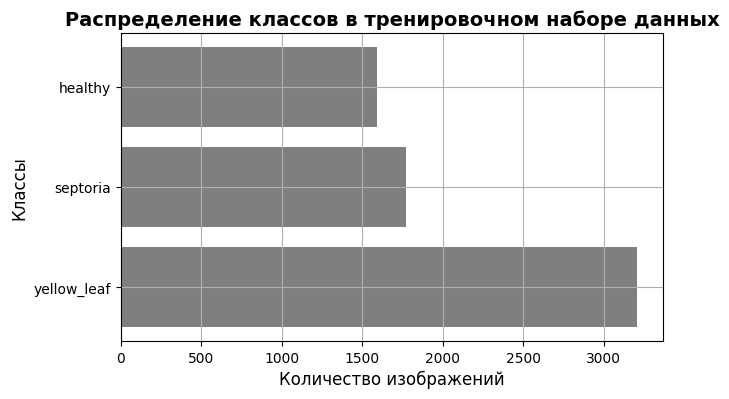

In [14]:
# количество изображений в тренировочной выборке на каждй класс
train = df['disease_type'].value_counts()
label = train.tolist()
index = train.index.tolist()

plt.figure(figsize=(7, 4))
plt.title("Распределение классов в тренировочном наборе данных", fontsize=14, fontweight="bold")
plt.xlabel("Количество изображений", fontsize=12)
plt.ylabel("Классы", fontsize=12)
plt.barh(index, label, color="#7f7f7f")
plt.yticks([0, 1, 2], index)
plt.grid(True)
plt.show()

In [15]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Fine-tune

In [28]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_auc_score, precision_recall_fscore_support, roc_curve, auc, classification_report


def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
  # подсчет матрицы ощибок
  cm = confusion_matrix(y_true, y_pred)

  # размер изображения
  plt.figure(figsize=figsize)

  # визуалиазиция матрицы ощибок
  disp = sns.heatmap(
      cm, annot=True, cmap='PuBu', cbar=False,
      annot_kws={"size": text_size}, fmt='g',
      linewidths=.5, linecolor='black', clip_on=False,
      xticklabels=classes, yticklabels=classes)

  disp.set_title('Матрица ощибок', fontsize=14, fontweight="bold")
  disp.set_xlabel('Предсказанные значения', fontsize=12)
  disp.set_ylabel('Истинные значения', fontsize=12)
  plt.yticks(rotation=0)

  plt.show()

  return

# Функция для подсчета метрик модели классификации
def generate_preformance_scores(y_true, y_pred, y_probabilities):

  cm = confusion_matrix(y_test, y_predicted)
  accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
  model_accuracy = balanced_accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                y_pred,
                                                                                average="weighted")
  model_roc_auc = roc_auc_score(y_true, y_probabilities, multi_class="ovr")

  print(f'Accuracy Score:\t\t{model_accuracy:.4f}')
  print(f'Precision_score:\t{model_precision:.4f}')
  print(f'Recall_score:\t\t{model_recall:.4f}')
  print(f'F1_score:\t\t{model_f1:.4f}')
  print(f'AUC Score:\t\t{model_roc_auc:.4f}')
  print("")
  for i in range(len(accuracy_per_class)):
    print(f"Accuracy Score {i}:\t{accuracy_per_class[i]:.4f}")
  print("")
  print(classification_report(y_test, y_predicted))

  return

def plot_multiclass_roc(y_test, y_prob, n_classes, figsize=(5,5)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title("График ROC-кривой", fontsize=14, fontweight="bold")
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='AUC = %0.3f for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()

## Модель 1

In [15]:
base_model = Xception(
                    weights='imagenet',
                    include_top=False)

83683744/83683744 [==============================] - 1s 0us/step


In [41]:
model = keras.Sequential([
    keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Conv2D(3, kernel_size=(3, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation="softmax")
])

# компиляция модели
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 62, 62, 3)         84        
                                                                 
 xception (Functional)       (None, None, None, 2048   20861480  
                             )                                   
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 16)                32784     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                

In [20]:
history = model.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val, y_val)
                    )

Epoch 1/5
132/132 [==============================] - 432s 3s/step - loss: 0.3501 - accuracy: 0.8806 - val_loss: 77.5450 - val_accuracy: 0.4278
Epoch 2/5
132/132 [==============================] - 435s 3s/step - loss: 0.1166 - accuracy: 0.9643 - val_loss: 0.1530 - val_accuracy: 0.9629
Epoch 3/5
132/132 [==============================] - 410s 3s/step - loss: 0.0871 - accuracy: 0.9710 - val_loss: 0.0409 - val_accuracy: 0.9876
Epoch 4/5
132/132 [==============================] - 395s 3s/step - loss: 0.0809 - accuracy: 0.9779 - val_loss: 10.5278 - val_accuracy: 0.5076
Epoch 5/5
132/132 [==============================] - 396s 3s/step - loss: 0.0920 - accuracy: 0.9788 - val_loss: 0.1253 - val_accuracy: 0.9648


In [21]:
model.save("/content/drive/MyDrive/Colab Notebooks/DL/Радмир/xception_image_class.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


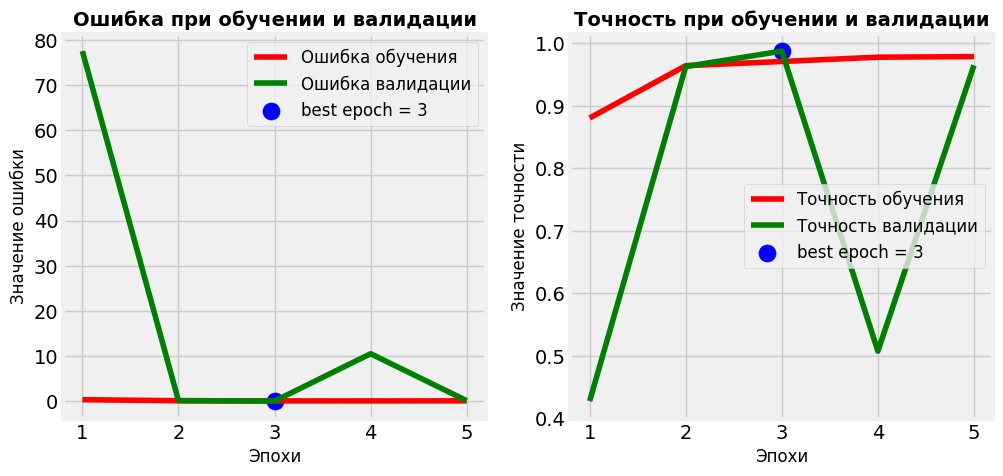

In [22]:
plot_training_curves(history)

In [23]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

42/42 [==============================] - 21s 457ms/step


In [30]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.9522
Precision_score:	0.9648
Recall_score:		0.9627
F1_score:		0.9625
AUC Score:		0.9953

Accuracy Score 0:	0.9680
Accuracy Score 1:	0.9984
Accuracy Score 2:	0.8902

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       375
           1       0.93      1.00      0.96       612
           2       0.99      0.89      0.94       328

    accuracy                           0.96      1315
   macro avg       0.97      0.95      0.96      1315
weighted avg       0.96      0.96      0.96      1315



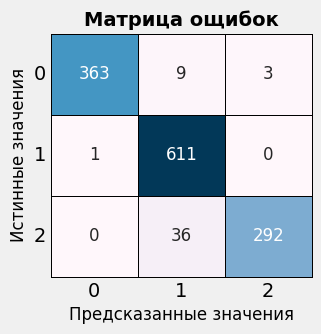

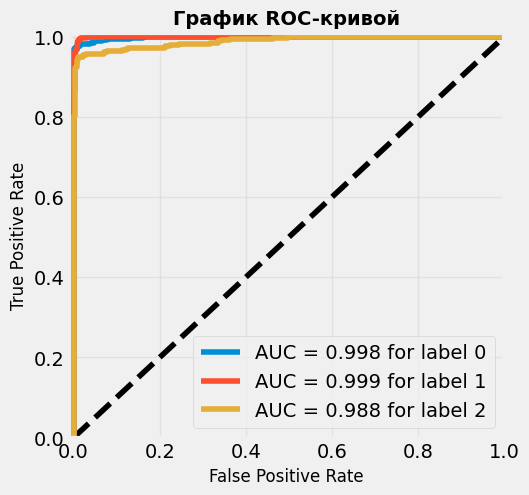

In [31]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_multiclass_roc(y_test, y_predicted_prob, 3)

# Transfer learning

## Модель 1

In [17]:
base_model = Xception(
                    weights='imagenet',
                    include_top=False,
                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

base_model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


In [18]:
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(3, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# компиляция модели
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 3)                 27        
                                                                 
Total params: 20927339 (79.83 MB)
Trainable params: 65859 (257.26 KB)
Non-trainable params: 20861480 (79.58 MB)
__________

In [21]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks_list
                    )

Epoch 1/10
132/132 [==============================] - 161s 1s/step - loss: 1.5201 - accuracy: 0.6441 - val_loss: 0.5557 - val_accuracy: 0.7424
Epoch 2/10
132/132 [==============================] - 148s 1s/step - loss: 0.5136 - accuracy: 0.7871 - val_loss: 0.4296 - val_accuracy: 0.8203
Epoch 3/10
132/132 [==============================] - 150s 1s/step - loss: 0.4223 - accuracy: 0.8378 - val_loss: 0.3630 - val_accuracy: 0.8441
Epoch 4/10
132/132 [==============================] - 135s 1s/step - loss: 0.3561 - accuracy: 0.8623 - val_loss: 0.3230 - val_accuracy: 0.8660
Epoch 5/10
132/132 [==============================] - 164s 1s/step - loss: 0.3718 - accuracy: 0.8513 - val_loss: 0.3308 - val_accuracy: 0.8641
Epoch 6/10
132/132 [==============================] - 156s 1s/step - loss: 0.2913 - accuracy: 0.8851 - val_loss: 0.3136 - val_accuracy: 0.8764
Epoch 7/10
132/132 [==============================] - 145s 1s/step - loss: 0.2673 - accuracy: 0.8968 - val_loss: 0.3383 - val_accuracy: 0.8831

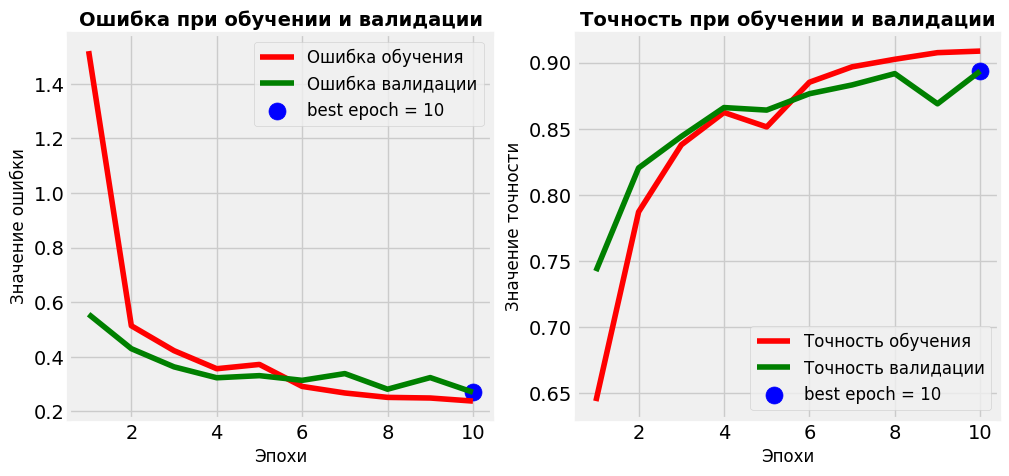

In [22]:
plot_training_curves(history)

In [24]:
y_predicted_prob = model.predict(X_test) # обучения модели на тестовом наборе
y_predicted = np.argmax(y_predicted_prob, axis=1) # перевод вероятностей в метки [0, 1] с порогом 0.5

42/42 [==============================] - 35s 804ms/step


In [36]:
generate_preformance_scores(y_test, y_predicted, y_predicted_prob)

Accuracy Score:		0.8920
Precision_score:	0.8877
Recall_score:		0.8783
F1_score:		0.8796
AUC Score:		0.9795

Accuracy Score 0:	0.8827
Accuracy Score 1:	0.8301
Accuracy Score 2:	0.9634

              precision    recall  f1-score   support

           0       0.76      0.88      0.82       375
           1       0.95      0.83      0.89       612
           2       0.91      0.96      0.94       328

    accuracy                           0.88      1315
   macro avg       0.87      0.89      0.88      1315
weighted avg       0.89      0.88      0.88      1315



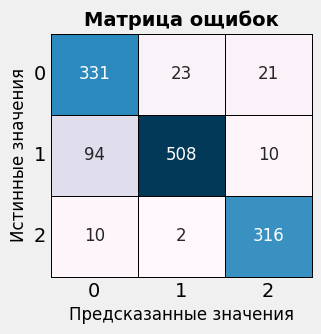

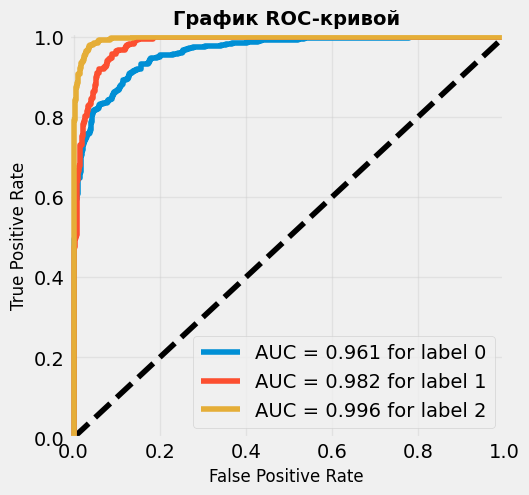

In [37]:
plot_confusion_matrix(y_test, y_predicted, figsize=(3, 3))
plot_multiclass_roc(y_test, y_predicted_prob, 3)